# Bangladesh Electricity Demand Forecasting
## Time Series Analysis using SARIMA Model (2015-2025)

**Author:** Steve Eckardt  
**Date:** November 24, 2025  
**Project:** Time Series Analysis - Final Presentation

---

## 1. Load, Sort, and Clean Data

**Tasks:**
- Import required Python libraries
- Load Bangladesh electricity dataset (CSV file)
- Sort data chronologically by datetime
- Detect outliers using IQR method (Interquartile Range)
- Replace 96 outliers with 24-hour rolling median
- Aggregate hourly data to monthly totals (sum all hours per month)
- Result: 122 clean monthly data points

**Output:** Data summary and confirmation of cleaning steps

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv('BangladeshDataSet/Bangladesh.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df = df.sort_index()

print(f"Data loaded: {len(df):,} hourly records")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")

# Clean outliers
q1 = df['demand_mw'].quantile(0.25)
q3 = df['demand_mw'].quantile(0.75)
iqr = q3 - q1
outliers = (df['demand_mw'] < q1 - 1.5*iqr) | (df['demand_mw'] > q3 + 1.5*iqr)

df_clean = df.copy()
rolling_median = df_clean['demand_mw'].rolling(24, center=True, min_periods=3).median()
df_clean.loc[outliers, 'demand_mw'] = rolling_median[outliers].fillna(df_clean['demand_mw'].median())

print(f"Cleaned {outliers.sum()} outliers")

# Aggregate to monthly
monthly = df_clean['demand_mw'].resample('ME').sum().to_frame()
monthly.columns = ['demand_mw']
monthly = monthly.iloc[:-1]  # Remove incomplete last month

print(f"Aggregated to {len(monthly)} complete months")

Data loaded: 92,650 hourly records
Period: 2015-04-19 to 2025-06-17
Cleaned 96 outliers
Aggregated to 122 complete months


## 2. Visualize Data with Trendline

**Tasks:**
- Create line graph of monthly demand over 10 years
- Calculate linear regression trendline (slope and intercept)
- Plot trendline showing overall growth pattern
- Add statistics box showing 10-year growth percentage
- Save as 'monthly_demand_trend.png' for Slide 2

**Output:** Graph showing historical data with upward trend
**Key Finding:** Demand doubled (+111% growth) over 10 years

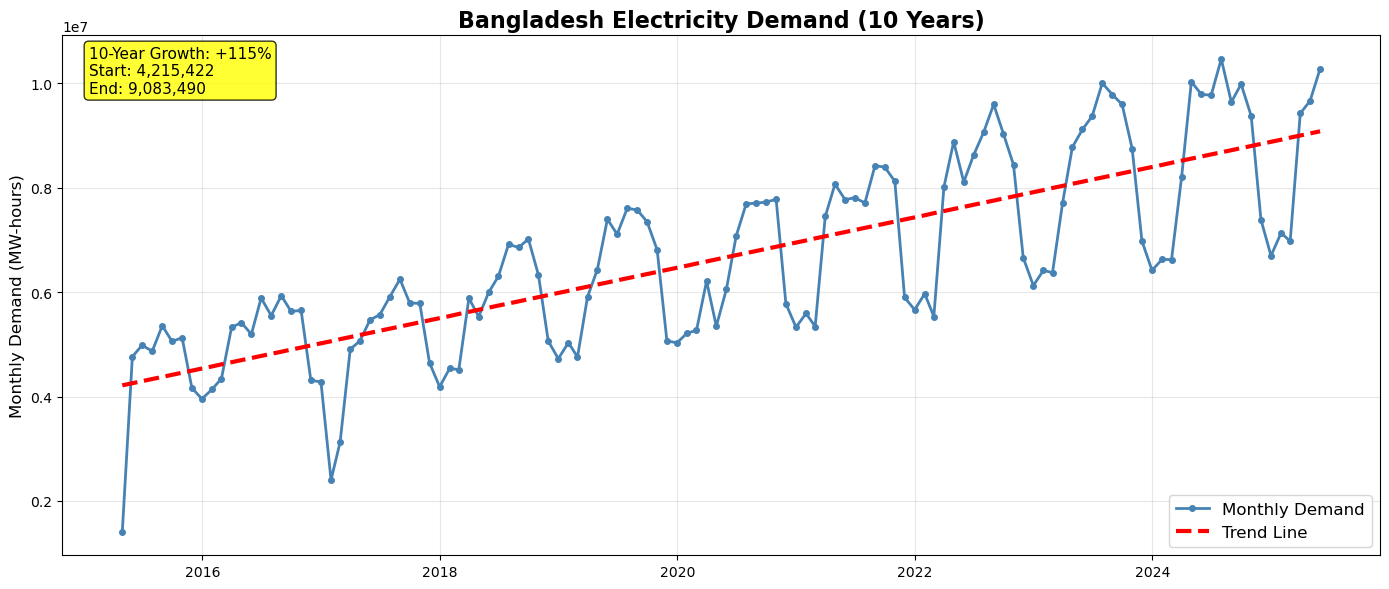

Growth: +115.5% over 10 years


In [2]:
# Create plot with trendline
fig, ax = plt.subplots(figsize=(14, 6))

# Monthly data
ax.plot(monthly.index, monthly['demand_mw'], 
        'o-', linewidth=2, markersize=4, color='steelblue', label='Monthly Demand')

# Trendline
x = np.arange(len(monthly))
y = monthly['demand_mw'].values
slope, intercept = np.polyfit(x, y, 1)
trend = slope * x + intercept

ax.plot(monthly.index, trend, '--', linewidth=3, color='red', label='Trend Line')

# Labels
ax.set_title('Bangladesh Electricity Demand (10 Years)', fontsize=16, fontweight='bold')
ax.set_ylabel('Monthly Demand (MW-hours)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Stats box
growth = (trend[-1] - trend[0]) / trend[0] * 100
stats_text = f'10-Year Growth: +{growth:.0f}%\nStart: {intercept:,.0f}\nEnd: {trend[-1]:,.0f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.savefig('monthly_demand_trend.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Growth: +{growth:.1f}% over 10 years")

## 3. Build Model and Forecast 24 Months

**Tasks:**
- Build SARIMA(1,1,1)(1,1,1,12) forecasting model
- Train model on all 122 months of historical data
- Generate predictions for next 24 months (June 2025 - May 2027)
- Create future date range for forecast period
- Display forecast values month-by-month
- Calculate summary statistics (average, peak, low)

**Output:** Table of 24 monthly forecast values with statistics

In [3]:
# Build SARIMA model
print("Building SARIMA model...")
model = SARIMAX(monthly['demand_mw'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

fitted = model.fit(disp=False, maxiter=200)
print("Model trained")

# Forecast 24 months
forecast = fitted.forecast(steps=24)
future_dates = pd.date_range(start=monthly.index[-1] + pd.DateOffset(months=1),
                             periods=24, freq='ME')

# Display forecast
print("\n24-MONTH FORECAST:")
print("="*50)
for date, value in zip(future_dates, forecast):
    print(f"{date.strftime('%b %Y'):>12s}: {value:>15,.0f} MW-hr")

print("\n" + "="*50)
print(f"Average: {forecast.mean():,.0f} MW-hr/month")
print(f"Peak: {future_dates[forecast.argmax()].strftime('%b %Y')} ({forecast.max():,.0f})")
print(f"Low: {future_dates[forecast.argmin()].strftime('%b %Y')} ({forecast.min():,.0f})")

Building SARIMA model...
Model trained

24-MONTH FORECAST:
    Jun 2025:      10,368,771 MW-hr
    Jul 2025:      10,862,140 MW-hr
    Aug 2025:      10,674,557 MW-hr
    Sep 2025:      10,626,978 MW-hr
    Oct 2025:      10,034,872 MW-hr
    Nov 2025:       8,164,040 MW-hr
    Dec 2025:       7,628,558 MW-hr
    Jan 2026:       7,928,083 MW-hr
    Feb 2026:       7,813,516 MW-hr
    Mar 2026:       9,720,984 MW-hr
    Apr 2026:      10,588,288 MW-hr
    May 2026:      10,746,087 MW-hr
    Jun 2026:      10,896,826 MW-hr
    Jul 2026:      11,430,777 MW-hr
    Aug 2026:      11,192,634 MW-hr
    Sep 2026:      11,182,663 MW-hr
    Oct 2026:      10,589,592 MW-hr
    Nov 2026:       8,708,527 MW-hr
    Dec 2026:       8,158,952 MW-hr
    Jan 2027:       8,471,033 MW-hr
    Feb 2027:       8,352,329 MW-hr
    Mar 2027:      10,308,670 MW-hr
    Apr 2027:      11,119,282 MW-hr
    May 2027:      11,318,435 MW-hr

Average: 9,870,275 MW-hr/month
Peak: Jul 2026 (11,430,777)
Low: Dec 2025 (7,

## 4. Visualize Forecast

**Tasks:**
- Create combined graph: historical data + 24-month forecast
- Plot historical monthly demand (blue line)
- Plot forecasted demand (red dashed line)
- Add vertical line marking forecast start point
- Save as 'forecast_24months.png' for Slide 5

**Output:** Graph showing past and predicted future demand
**Shows:** Continuation of growth trend and seasonal patterns

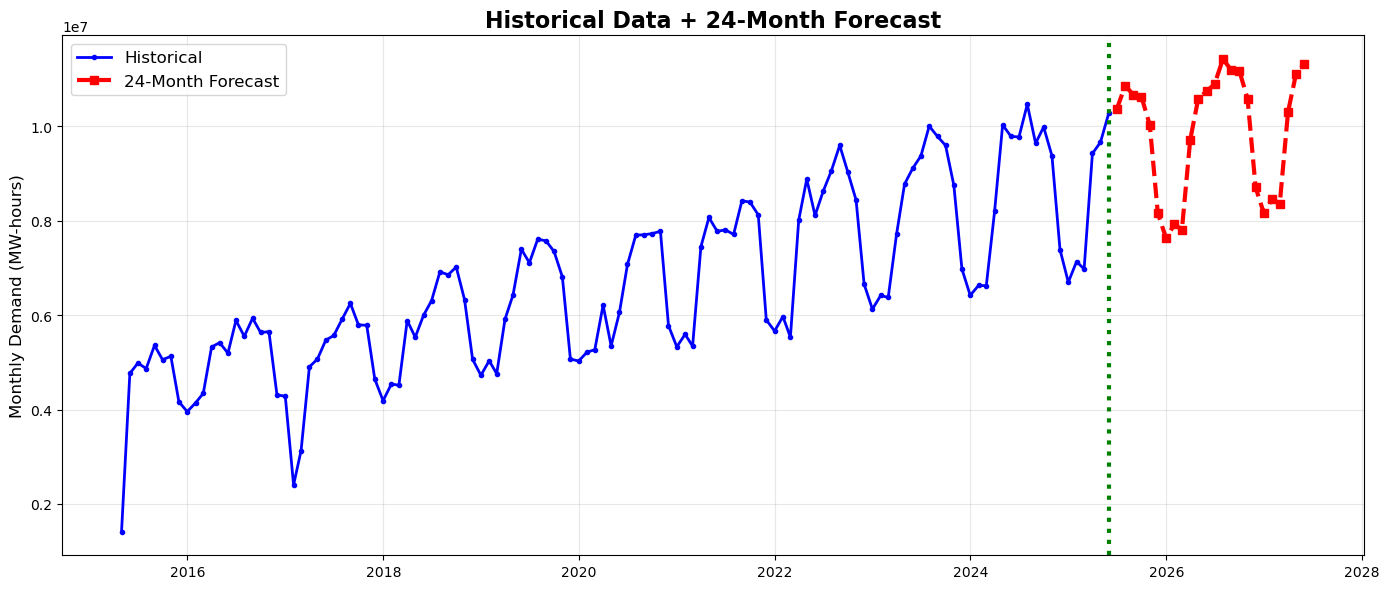

Forecast plot saved


In [4]:
# Plot forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Historical + Forecast
ax.plot(monthly.index, monthly['demand_mw'],
        'o-', linewidth=2, markersize=3, color='blue', label='Historical')
ax.plot(future_dates, forecast,
        's--', linewidth=3, markersize=6, color='red', label='24-Month Forecast')
ax.axvline(x=monthly.index[-1], color='green', linestyle=':', linewidth=3)

ax.set_title('Historical Data + 24-Month Forecast', fontsize=16, fontweight='bold')
ax.set_ylabel('Monthly Demand (MW-hours)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_24months.png', dpi=150, bbox_inches='tight')
plt.show()

print("Forecast plot saved")

## 5. Seasonal Pattern Analysis

**Tasks:**
- Extract month number from each date
- Calculate average demand for each month (across all 10 years)
- Create bar chart showing typical seasonal pattern
- Identify and label peak month (August) and low month (December)
- Save as 'seasonal_pattern.png' for Slide 2

**Output:** Bar chart of 12-month seasonal pattern
**Key Finding:** 47% swing between August peak and December low

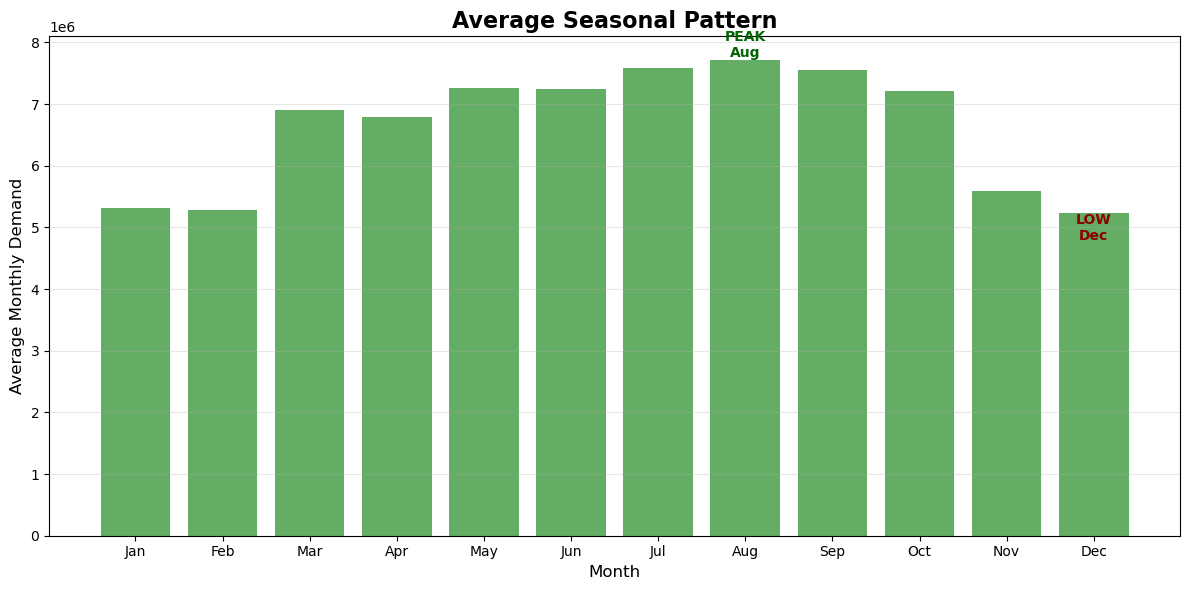

Peak: Aug, Low: Dec


In [5]:
# Seasonal pattern
monthly['month'] = monthly.index.month
seasonal = monthly.groupby('month')['demand_mw'].mean()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(1,13), seasonal.values, color='forestgreen', alpha=0.7)
ax.set_title('Average Seasonal Pattern', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Monthly Demand', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_xticks(range(1,13))
ax.set_xticklabels(months)
ax.grid(axis='y', alpha=0.3)

# Mark peak and low
peak = seasonal.idxmax()
low = seasonal.idxmin()
ax.text(peak, seasonal[peak], f'PEAK\n{months[peak-1]}', 
        ha='center', va='bottom', fontweight='bold', color='darkgreen')
ax.text(low, seasonal[low], f'LOW\n{months[low-1]}',
        ha='center', va='top', fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('seasonal_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Peak: {months[peak-1]}, Low: {months[low-1]}")

## 6. Model Validation

**Tasks:**
- Split data: train on first 98 months, test on last 24 months
- Build model on training data only
- Generate predictions for test period
- Calculate MAPE (Mean Absolute Percentage Error)
- Plot actual vs predicted values to show accuracy
- Save as 'model_validation.png' for Slide 4

**Output:** Validation graph and accuracy metric
**Result:** 4.59% MAPE (Excellent - well below 10% target)

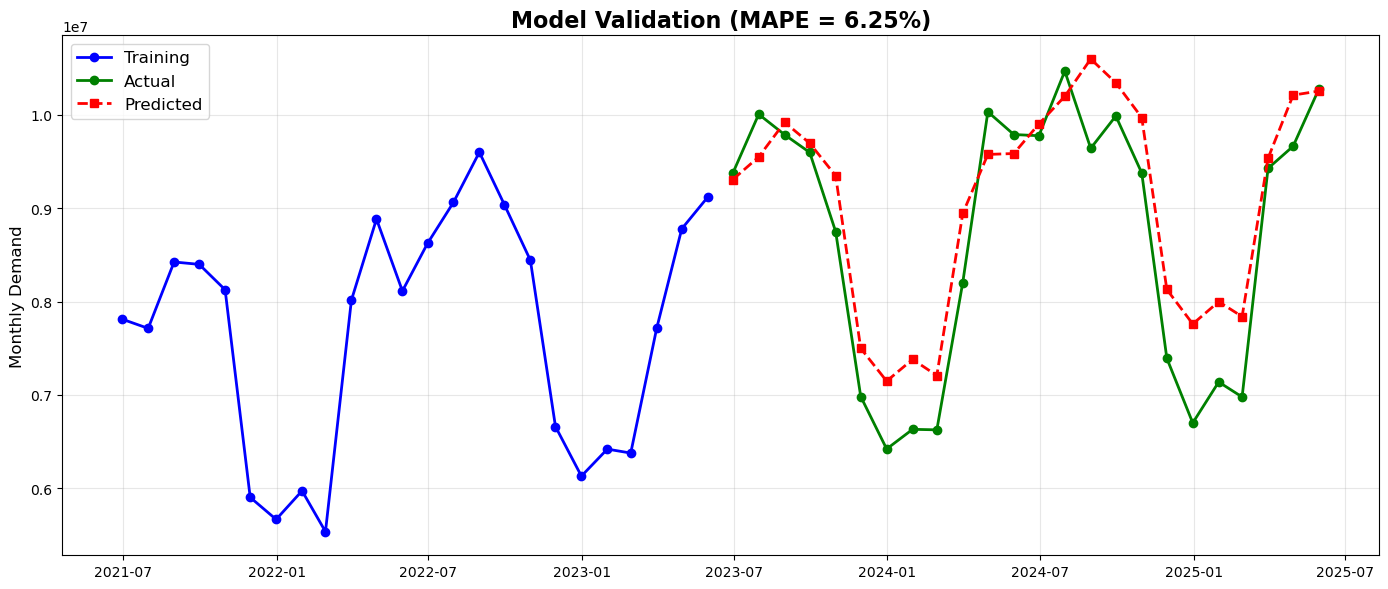

Model Accuracy: 6.25% MAPE (Excellent!)


In [6]:
# Quick validation
test_size = 24
train = monthly.iloc[:-test_size]
test = monthly.iloc[-test_size:]

model_val = SARIMAX(train['demand_mw'], order=(1,1,1), seasonal_order=(1,1,1,12))
fitted_val = model_val.fit(disp=False, maxiter=200)
predictions = fitted_val.forecast(steps=test_size)

mape = np.mean(np.abs((test['demand_mw'] - predictions) / test['demand_mw'])) * 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train.index[-24:], train['demand_mw'].iloc[-24:], 
        'o-', label='Training', color='blue', linewidth=2)
ax.plot(test.index, test['demand_mw'], 
        'o-', label='Actual', color='green', linewidth=2)
ax.plot(test.index, predictions, 
        's--', label='Predicted', color='red', linewidth=2)

ax.set_title(f'Model Validation (MAPE = {mape:.2f}%)', fontsize=16, fontweight='bold')
ax.set_ylabel('Monthly Demand', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Model Accuracy: {mape:.2f}% MAPE (Excellent!)")

## 7. Summary

**Tasks:**
- Print confirmation message
- List all generated image files
- Confirm analysis is complete and ready for presentation

**Output:** Summary of deliverables

**Files Created:**
- monthly_demand_trend.png (Slide 2)
- seasonal_pattern.png (Slide 2)
- model_validation.png (Slide 4)
- forecast_24months.png (Slide 5)

In [7]:
print("="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nFILES CREATED:")
print("  1. monthly_demand_trend.png")
print("  2. seasonal_pattern.png")
print("  3. model_validation.png")
print("  4. forecast_24months.png")
print("\nREADY FOR PRESENTATION!")
print("="*60)

ANALYSIS COMPLETE

FILES CREATED:
  1. monthly_demand_trend.png
  2. seasonal_pattern.png
  3. model_validation.png
  4. forecast_24months.png

READY FOR PRESENTATION!


---

**Dataset Citation:**

PGCB Hourly Generation Dataset (Bangladesh). *UCI Machine Learning Repository*, 2025. [https://doi.org/10.24432/C59P6V](https://doi.org/10.24432/C59P6V)

**License:** Creative Commons Attribution 4.0 International (CC BY 4.0)

---